# Tutorial 5: Inception, ResNet and DenseNet

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)


**Filled notebook:**
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.ipynb)   
**Pre-trained models:**
[![View files on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/saved_models/tree/main/tutorial5)
[![GoogleDrive](https://img.shields.io/static/v1.svg?logo=google-drive&logoColor=yellow&label=GDrive&message=Download&color=yellow)](https://drive.google.com/drive/folders/1zOgLKmYJ2V3uHz57nPUMY6tq15RmEtNg?usp=sharing)   
**Recordings:**
[![YouTube - Part 1](https://img.shields.io/static/v1.svg?logo=youtube&label=YouTube&message=Part%201&color=red)](https://youtu.be/vjSSyGxlczs)
[![YouTube - Part 2](https://img.shields.io/static/v1.svg?logo=youtube&label=YouTube&message=Part%202&color=red)](https://youtu.be/9yRXqYJDHr4)
[![YouTube - Part 3](https://img.shields.io/static/v1.svg?logo=youtube&label=YouTube&message=Part%203&color=red)](https://youtu.be/ELEqNwv9vkE)   
**JAX+Flax version:**
[![View on RTD](https://img.shields.io/static/v1.svg?logo=readthedocs&label=RTD&message=View%20On%20RTD&color=8CA1AF)](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial5/Inception_ResNet_DenseNet.html)   
**Author:** Phillip Lippe

<div class="alert alert-info">

**Note:** Interested in JAX? Check out our [JAX+Flax version](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial5/Inception_ResNet_DenseNet.html) of this tutorial!
</div>

In this tutorial, we will implement and discuss variants of modern CNN architectures. There have been many different architectures been proposed over the past few years. Some of the most impactful ones, and still relevant today, are the following: [GoogleNet](https://arxiv.org/abs/1409.4842)/Inception architecture (winner of ILSVRC 2014), [ResNet](https://arxiv.org/abs/1512.03385) (winner of ILSVRC 2015), and [DenseNet](https://arxiv.org/abs/1608.06993) (best paper award CVPR 2017). All of them were state-of-the-art models when being proposed, and the core ideas of these networks are the foundations for most current state-of-the-art architectures. Thus, it is important to understand these architectures in detail and learn how to implement them.

Let's start with importing our standard libraries here.

In [ ]:
## Standard libraries
import os
import numpy as np
import random
from PIL import Image
from types import SimpleNamespace

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

<ipython-input-1-7fa41da6c4ce>:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


We will use the same `set_seed` function as in the previous tutorials, as well as the path variables `DATASET_PATH` and `CHECKPOINT_PATH`. Adjust the paths if necessary.

In [ ]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial5"

# Function for setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
train_dataset = CIFAR10(root=DATASET_PATH, train=True, download=True)
DATA_MEANS = (train_dataset.data / 255.0).mean(axis=(0,1,2))
DATA_STD = (train_dataset.data / 255.0).std(axis=(0,1,2))
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)

Files already downloaded and verified
Data mean [0.49139968 0.48215841 0.44653091]
Data std [0.24703223 0.24348513 0.26158784]


We will use this information to define a `transforms.Normalize` module which will normalize our data accordingly. Additionally, we will use data augmentation during training. This reduces the risk of overfitting and helps CNNs to generalize better. Specifically, we will apply two random augmentations.

First, we will flip each image horizontally by a chance of 50% (`transforms.RandomHorizontalFlip`). The object class usually does not change when flipping an image, and we don't expect any image information to be dependent on the horizontal orientation. This would be however different if we would try to detect digits or letters in an image, as those have a certain orientation.

The second augmentation we use is called `transforms.RandomResizedCrop`. This transformation crops the image in a small range, eventually changing the aspect ratio, and scaling it back afterward to the previous size. Therefore, the actual pixel values change while the content or overall semantics of the image stays the same.

We will randomly split the training dataset into a training and a validation set. The validation set will be used for determining early stopping. After finishing the training, we test the models on the CIFAR test set.

In [ ]:
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32), scale=(0.8,1.0), ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
set_seed(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
set_seed(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


To verify that our normalization works, we can print out the mean and standard deviation of the single batch. The mean should be close to 0 and the standard deviation close to 1 for each channel:

In [ ]:
imgs, _ = next(iter(train_loader))
print("Batch mean", imgs.mean(dim=[0,2,3]))
print("Batch std", imgs.std(dim=[0,2,3]))

Batch mean tensor([0.0231, 0.0006, 0.0005])
Batch std tensor([0.9865, 0.9849, 0.9868])


Finally, let's visualize a few images from the training set, and how they look like after random data augmentation:

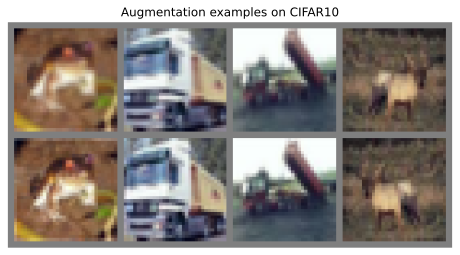

In [ ]:
NUM_IMAGES = 4
images = [train_dataset[idx][0] for idx in range(NUM_IMAGES)]
orig_images = [Image.fromarray(train_dataset.data[idx]) for idx in range(NUM_IMAGES)]
orig_images = [test_transform(img) for img in orig_images]

img_grid = torchvision.utils.make_grid(torch.stack(images + orig_images, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Augmentation examples on CIFAR10")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

## PyTorch Lightning

In this notebook and in many following ones, we will make use of the library [PyTorch Lightning](https://www.pytorchlightning.ai/). PyTorch Lightning is a framework that simplifies your code needed to train, evaluate, and test a model in PyTorch. It also handles logging into [TensorBoard](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html), a visualization toolkit for ML experiments, and saving model checkpoints automatically with minimal code overhead from our side. This is extremely helpful for us as we want to focus on implementing different model architectures and spend little time on other code overhead. Note that at the time of writing/teaching, the framework has been released in version 1.8. Future versions might have a slightly changed interface and thus might not work perfectly with the code (we will try to keep it up-to-date as much as possible).

Now, we will take the first step in PyTorch Lightning, and continue to explore the framework in our other tutorials. First, we import the library:

In [ ]:
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.5
    import pytorch_lightning as pl

PyTorch Lightning comes with a lot of useful functions, such as one for setting the seed:

In [ ]:
# Setting the seed
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

Thus, in the future, we don't have to define our own `set_seed` function anymore.

In PyTorch Lightning, we define `pl.LightningModule`'s (inheriting from `torch.nn.Module`) that organize our code into 5 main sections:

1. Initialization (`__init__`), where we create all necessary parameters/models
2. Optimizers (`configure_optimizers`) where we create the optimizers, learning rate scheduler, etc.
3. Training loop (`training_step`) where we only have to define the loss calculation for a single batch (the loop of optimizer.zero_grad(), loss.backward() and optimizer.step(), as well as any logging/saving operation, is done in the background)
4. Validation loop (`validation_step`) where similarly to the training, we only have to define what should happen per step
5. Test loop (`test_step`) which is the same as validation, only on a test set.

Therefore, we don't abstract the PyTorch code, but rather organize it and define some default operations that are commonly used. If you need to change something else in your training/validation/test loop, there are many possible functions you can overwrite (see the [docs](https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html) for details).

Now we can look at an example of how a Lightning Module for training a CNN looks like:

In [ ]:
class CIFARModule(pl.LightningModule):

    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):
        """
        Inputs:
            model_name - Name of the model/CNN to run. Used for creating the model (see function below)
            model_hparams - Hyperparameters for the model, as dictionary.
            optimizer_name - Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """
        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        # Create model
        self.model = create_model(model_name, model_hparams)
        # Create loss module
        self.loss_module = nn.CrossEntropyLoss()
        # Example input for visualizing the graph in Tensorboard
        self.example_input_array = torch.zeros((1, 3, 32, 32), dtype=torch.float32)

    def forward(self, imgs):
        # Forward function that is run when visualizing the graph
        return self.model(imgs)

    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here for details: https://arxiv.org/pdf/1711.05101.pdf)
            optimizer = optim.AdamW(
                self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f"Unknown optimizer: \"{self.hparams.optimizer_name}\""

        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_loss', loss, prog_bar=True)
        return loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        self.log('test_acc', acc)

We see that the code is organized and clear, which helps if someone else tries to understand your code.

Another important part of PyTorch Lightning is the concept of callbacks. Callbacks are self-contained functions that contain the non-essential logic of your Lightning Module. They are usually called after finishing a training epoch, but can also influence other parts of your training loop. For instance, we will use the following two pre-defined callbacks: `LearningRateMonitor` and `ModelCheckpoint`. The learning rate monitor adds the current learning rate to our TensorBoard, which helps to verify that our learning rate scheduler works correctly. The model checkpoint callback allows you to customize the saving routine of your checkpoints. For instance, how many checkpoints to keep, when to save, which metric to look out for, etc. We import them below:

In [ ]:
# Callbacks
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

To allow running multiple different models with the same Lightning module, we define a function below that maps a model name to the model class. At this stage, the dictionary `model_dict` is empty, but we will fill it throughout the notebook with our new models.

In [ ]:
model_dict = {}

def create_model(model_name, model_hparams):
    if model_name in model_dict:
        print(model_hparams)
        return model_dict[model_name](**model_hparams)
    else:
        assert False, f"Unknown model name \"{model_name}\". Available models are: {str(model_dict.keys())}"

Similarly, to use the activation function as another hyperparameter in our model, we define a "name to function" dict below:

In [ ]:
act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "leakyrelu": nn.LeakyReLU,
    "gelu": nn.GELU
}

If we pass the classes or objects directly as an argument to the Lightning module, we couldn't take advantage of PyTorch Lightning's automatically hyperparameter saving and loading.

Besides the Lightning module, the second most important module in PyTorch Lightning is the `Trainer`. The trainer is responsible to execute the training steps defined in the Lightning module and completes the framework. Similar to the Lightning module, you can override any key part that you don't want to be automated, but the default settings are often the best practice to do. For a full overview, see the [documentation](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html). The most important functions we use below are:

* `trainer.fit`: Takes as input a lightning module, a training dataset, and an (optional) validation dataset. This function trains the given module on the training dataset with occasional validation (default once per epoch, can be changed)
* `trainer.test`: Takes as input a model and a dataset on which we want to test. It returns the test metric on the dataset.

For training and testing, we don't have to worry about things like setting the model to eval mode (`model.eval()`) as this is all done automatically. See below how we define a training function for our models:

In [ ]:
def train_model(model_name, save_name=None, load_ckpt=False, **kwargs):
    """
    Inputs:
        model_name - Name of the model you want to run. Is used to look up the class in "model_dict"
        save_name (optional) - If specified, this name will be used for creating the checkpoint and logging directory.
    """
    if save_name is None:
        save_name = model_name

    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),                          # Where to save models
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",                     # We run on a GPU (if possible)
                         devices=1,                                                                          # How many GPUs/CPUs we want to use (1 is enough for the notebooks)
                         max_epochs=50,                                                                     # How many epochs to train for if no patience is set
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
                                    LearningRateMonitor("epoch")],                                           # Log learning rate every epoch
                         enable_progress_bar=True)                                                           # Set to False if you do not want a progress bar
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, save_name + ".ckpt")
    if load_ckpt and os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = CIFARModule.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42) # To be reproducable
        model = CIFARModule(model_name=model_name, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = CIFARModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

Finally, we can focus on the Convolutional Neural Networks we want to implement today:  ResNet

## ResNet

The [ResNet](https://arxiv.org/abs/1512.03385) paper is one of the  [most cited AI papers](https://www.natureindex.com/news-blog/google-scholar-reveals-most-influential-papers-research-citations-twenty-twenty), and has been the foundation for neural networks with more than 1,000 layers. Despite its simplicity, the idea of residual connections is highly effective as it supports stable gradient propagation through the network. Instead of modeling $x_{l+1}=F(x_{l})$, we model $x_{l+1}=x_{l}+F(x_{l})$ where $F$ is a non-linear mapping (usually a sequence of NN modules likes convolutions, activation functions, and normalizations). If we do backpropagation on such residual connections, we obtain:

$$\frac{\partial x_{l+1}}{\partial x_{l}} = \mathbf{I} + \frac{\partial F(x_{l})}{\partial x_{l}}$$

The bias towards the identity matrix guarantees a stable gradient propagation being less effected by $F$ itself. There have been many variants of ResNet proposed, which mostly concern the function $F$, or operations applied on the sum. In this tutorial, we look at two of them: the original ResNet block, and the [Pre-Activation ResNet block](https://arxiv.org/abs/1603.05027). We visually compare the blocks below (figure credit - [He et al.](https://arxiv.org/abs/1603.05027)):

<center width="100%"><img src="resnet_block.svg" style="display: block; margin-left: auto; margin-right: auto;" width="300px"/></center>

The original ResNet block applies a non-linear activation function, usually ReLU, after the skip connection. In contrast, the pre-activation ResNet block applies the non-linearity at the beginning of $F$. Both have their advantages and disadvantages. For very deep network, however, the pre-activation ResNet has shown to perform better as the gradient flow is guaranteed to have the identity matrix as calculated above, and is not harmed by any non-linear activation applied to it. For comparison, in this notebook, we implement both ResNet types as shallow networks.

Let's start with the original ResNet block. The visualization above already shows what layers are included in $F$. One special case we have to handle is when we want to reduce the image dimensions in terms of width and height. The basic ResNet block requires $F(x_{l})$ to be of the same shape as $x_{l}$. Thus, we need to change the dimensionality of $x_{l}$ as well before adding to $F(x_{l})$. The original implementation used an identity mapping with stride 2 and padded additional feature dimensions with 0. However, the more common implementation is to use a 1x1 convolution with stride 2 as it allows us to change the feature dimensionality while being efficient in parameter and computation cost. The code for the ResNet block is relatively simple, and shown below:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Import our resnet
from models.resnet import ResNet
model_dict["ResNet"] = ResNet

In [ ]:
resnet_model, resnet_results = train_model(model_name="ResNet",
                                           model_hparams={"num_classes": 10,
                                                          "c_hidden": [16,32,64],
                                                          "num_blocks": [3,3,3],
                                                          },
                                           optimizer_name="SGD",
                                           optimizer_hparams={"lr": 0.1,
                                                              "momentum": 0.9,
                                                              "weight_decay": 1e-4})

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type             | Params | Mode  | In sizes       | Out sizes
--------------------------------------------------------------------------------------
0 | model       | ResNet           | 272 K  | train | [1, 3, 32, 32] | [1, 10]  
1 | loss_module | CrossEntropyLoss | 0      | train | ?              | ?        
--------------------------------------------------------------------------------------
272 K     Trainable params
0         Non-trainable params
272 K     Total params
1.089     Total estimated model params size (MB)
76        Modules in trai

{'num_classes': 10, 'c_hidden': [16, 32, 64], 'num_blocks': [3, 3, 3]}
Downsampling from 16 to 32
Downsampling from 32 to 64


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'num_classes': 10, 'c_hidden': [16, 32, 64], 'num_blocks': [3, 3, 3]}
Downsampling from 16 to 32
Downsampling from 32 to 64


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7825a5e09e10>Exception ignored in: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7825a5e09e10>    self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
if w.is_alive():    Exception ignored in: self._shutdown_workers()

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7825a5e09e10>    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/proces

# Training results #
```
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
```

| # | Name        | Type             | Params | Mode  | In sizes       | Out sizes |
| ---| -------    | ------- |---------- | -------  | ------- | ------- |
|0 | model       | ResNet           | 272 K  | train | [1, 3, 32, 32] | [1, 10]  |
|1 | loss_module | CrossEntropyLoss | 0      | train | ?              | ?        |

```
{'num_classes': 10, 'c_hidden': [16, 32, 64], 'num_blocks': [3, 3, 3]}
Downsampling from 16 to 32
Downsampling from 32 to 64
Epoch 49: 100% 351/351 [00:34<00:00, 10.15it/s, v_num=6, train_loss=0.350, train_acc=0.900]
```